In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
from scipy import signal

from astropy import units
from astropy.time import Time

import glob

import kf_lib as kf

## telescope location and obs data
This is useful for tracking source positions

In [3]:
pointing = 0

input_labels = ['EX','EY','WX','WY']

rfof_tx_labels = []
rfof_tx_labels = []


KF = kf.get_telescope_loc()

KF

<EarthLocation (5076226.74146934, 2050413.45413339, -3263923.86656525) m>

## datasets

In [6]:
# ls -lth /Users/anthonywalters/Work/HIRAX/Klerefontein/data/
ls -lth /home/uranus/HIRAX-pipeline/data/

SyntaxError: invalid syntax (669801881.py, line 2)

### load correlator data

In [4]:
path_to_data = '/home/uranus/HIRAX-pipeline/data/20241211T084327Z_HartRAO_corr/*.h5'
file_list = sorted(glob.glob(path_to_data))

test_freqs = [450, 550, 650, 750]
test_freqs = [425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775]

vis, times, freqs, products, gain_coeff, gain_exp = kf.load_hd5_list(file_list, test_freqs=None, only_autos=False, flip_freq_ax=True)
times_sast = times + 2*units.hour

There are 14 files in the list
Merged vis. shape is (6694, 1024, 10)
Obs. data span is 2024-12-11 08:43:27.752 - 2024-12-11 18:07:34.251 UTC


### load digital gains, undo

In [13]:
!h5ls  ./data/20250617T134809Z_KF_digitalgain_day2-poleq/00000052.h5

compute_time             Dataset {1/Inf, 16}
gain_coeff               Dataset {1/Inf, 1024, 16}
gain_exp                 Dataset {1/Inf, 16}
index_map                Group
update_id                Dataset {1/Inf}


In [14]:
path_to_digigain = '/Users/anthonywalters/Work/HIRAX/Klerefontein/data/20250617T134809Z_KF_digitalgain_day2-poleq/*.h5'
path_to_digigain = sorted(glob.glob(path_to_digigain))[0]

gains = kf.load_digital_gains(path_to_digigain, flip_freq_ax=True)


Digital gains have shape (1, 1024, 16)


In [15]:
vis2 = kf.undo_digital_gains(vis, products, gains)

## make some plots

### passband, all products,  and intervals

In [6]:
# NICO: no digi gain corr
vis2 = vis
delta_t = 2*units.hour

start_time = Time('2025-06-17T16:00:00')
stop_time = start_time + delta_t

time_idxs = np.where((times_sast >= start_time) & (times_sast <= stop_time))[0]

to_plot = np.abs(vis[time_idxs,:,:])
to_plot2 = np.abs(vis2[time_idxs,:,:])


fig, ax = kf.plot_passband_3up(to_plot, freqs, products, gains, to_plot2, only_autos=False, percentile=50, shade_intervals=[1,99])


NameError: name 'gains' is not defined

### passband, only autos

In [7]:
fig, ax = kf.plot_passband_3up(to_plot, freqs, products, gains, to_plot2, only_autos=True, percentile=50, shade_intervals=[5,95])


NameError: name 'gains' is not defined

### waterfalls, all products, visibility magnitude

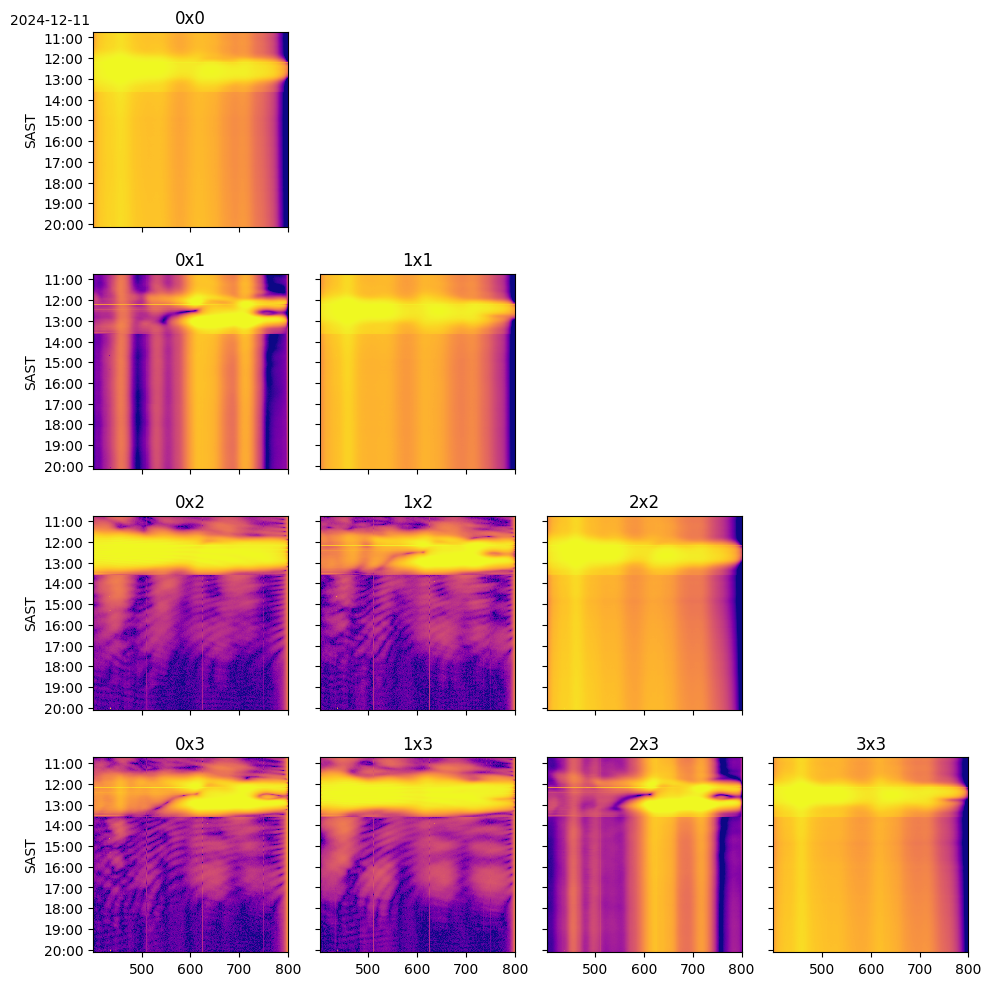

In [8]:
to_plot = np.abs(vis2)

fig, ax = kf.plot_waterfall_triangle(to_plot, times_sast, freqs, products, cmap='plasma', sat_percent=2, norm='log')

### waterfall, all products, visibilty phase

In [9]:
fig, ax = kf.plot_waterfall_triangle(vis2, times_sast, freqs, products, hsv=True)

: 

### waterfalls, relatve change in dB, only autos

/var/folders/0x/tskgr_9s2_b35dr22g9d022c0000gn/T/ipykernel_28496/3206431768.py:5: RuntimeWarning: divide by zero encountered in log10
  to_plot = 10*np.log10(to_plot/scale)
/var/folders/0x/tskgr_9s2_b35dr22g9d022c0000gn/T/ipykernel_28496/3206431768.py:5: RuntimeWarning: invalid value encountered in log10
  to_plot = 10*np.log10(to_plot/scale)


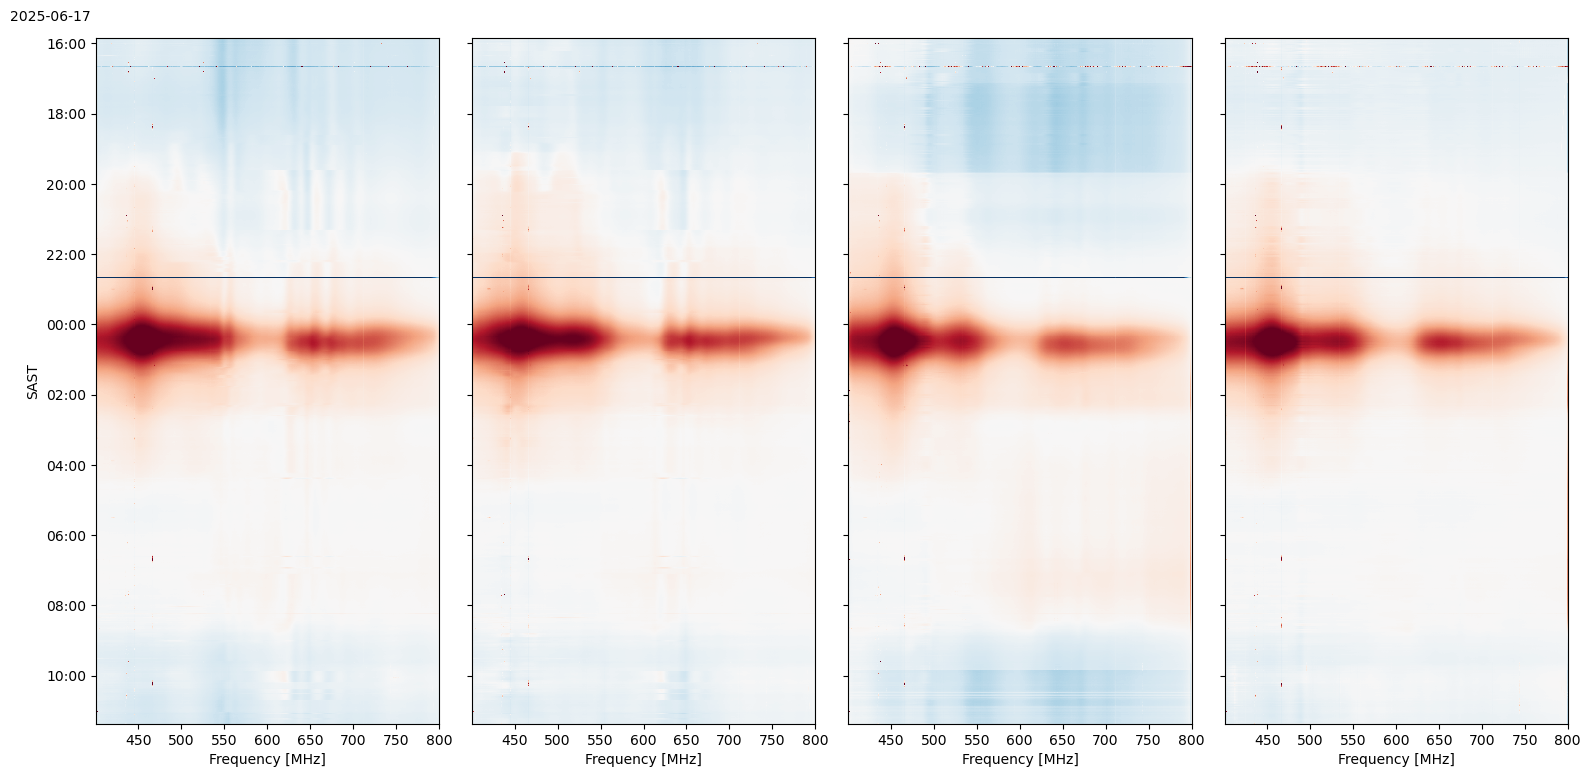

In [27]:
auto_idxs = kf.get_auto_idxs(products)

to_plot = np.real(vis)
scale = np.percentile(to_plot, 50, axis=0)
to_plot = 10*np.log10(to_plot/scale)

fig, ax = kf.plot_waterfall_columns(to_plot, times_sast, freqs, auto_idxs, cmap='RdBu_r', vlims=[-5,5], norm='linear')

fig.tight_layout()

### waterfalls, visibility phase, co-pol interferometric products

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


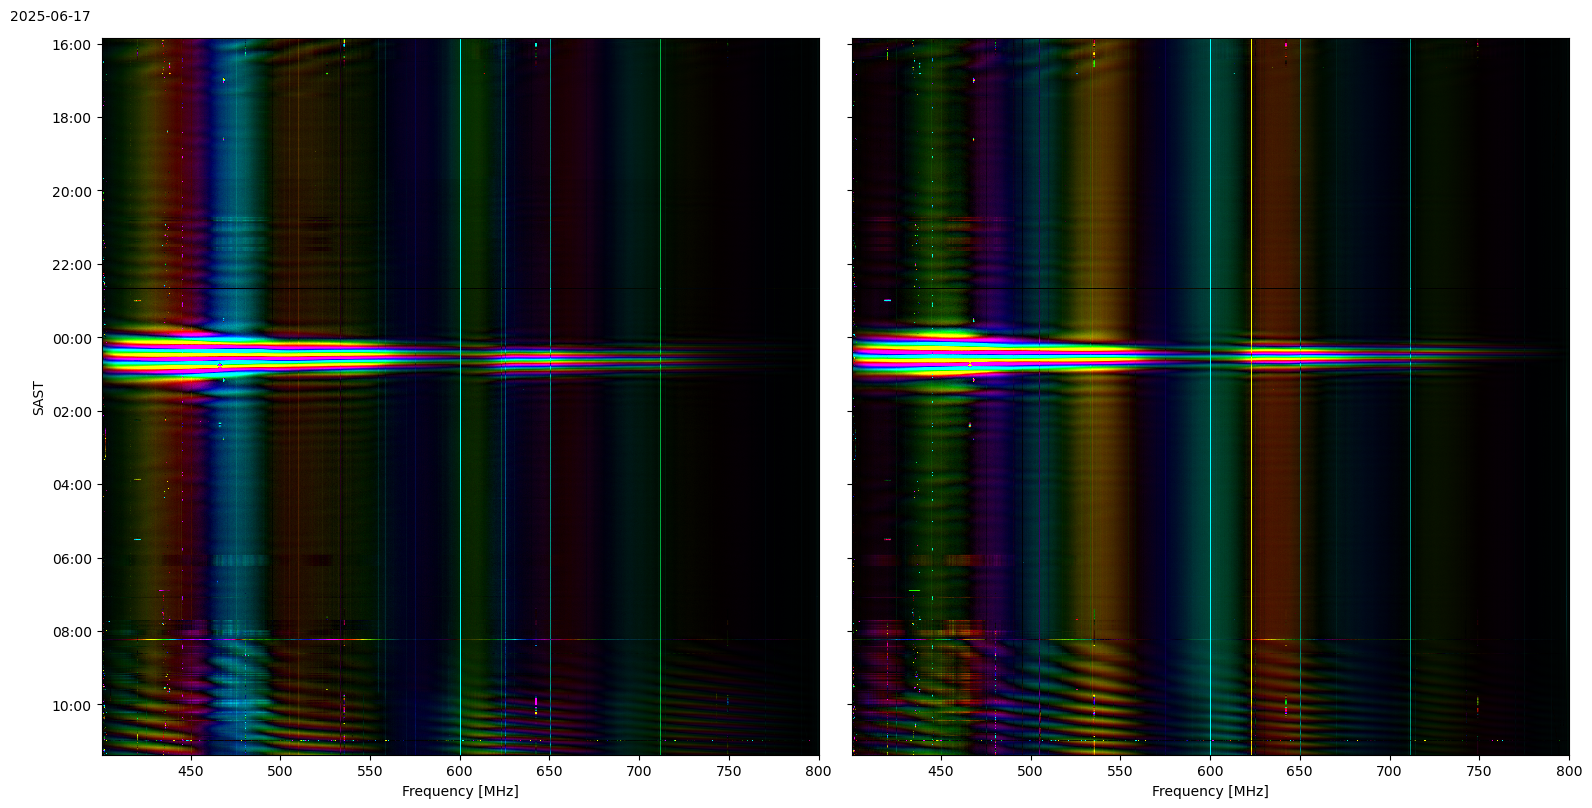

In [29]:
copol_idxs = [2, 6]

fig, ax = kf.plot_waterfall_columns(vis2, times_sast, freqs, copol_idxs, hsv=True, scale=1)
fig.tight_layout()

### timeseries of the autos

(<Figure size 1600x900 with 1 Axes>, <Axes: ylabel='dB'>)

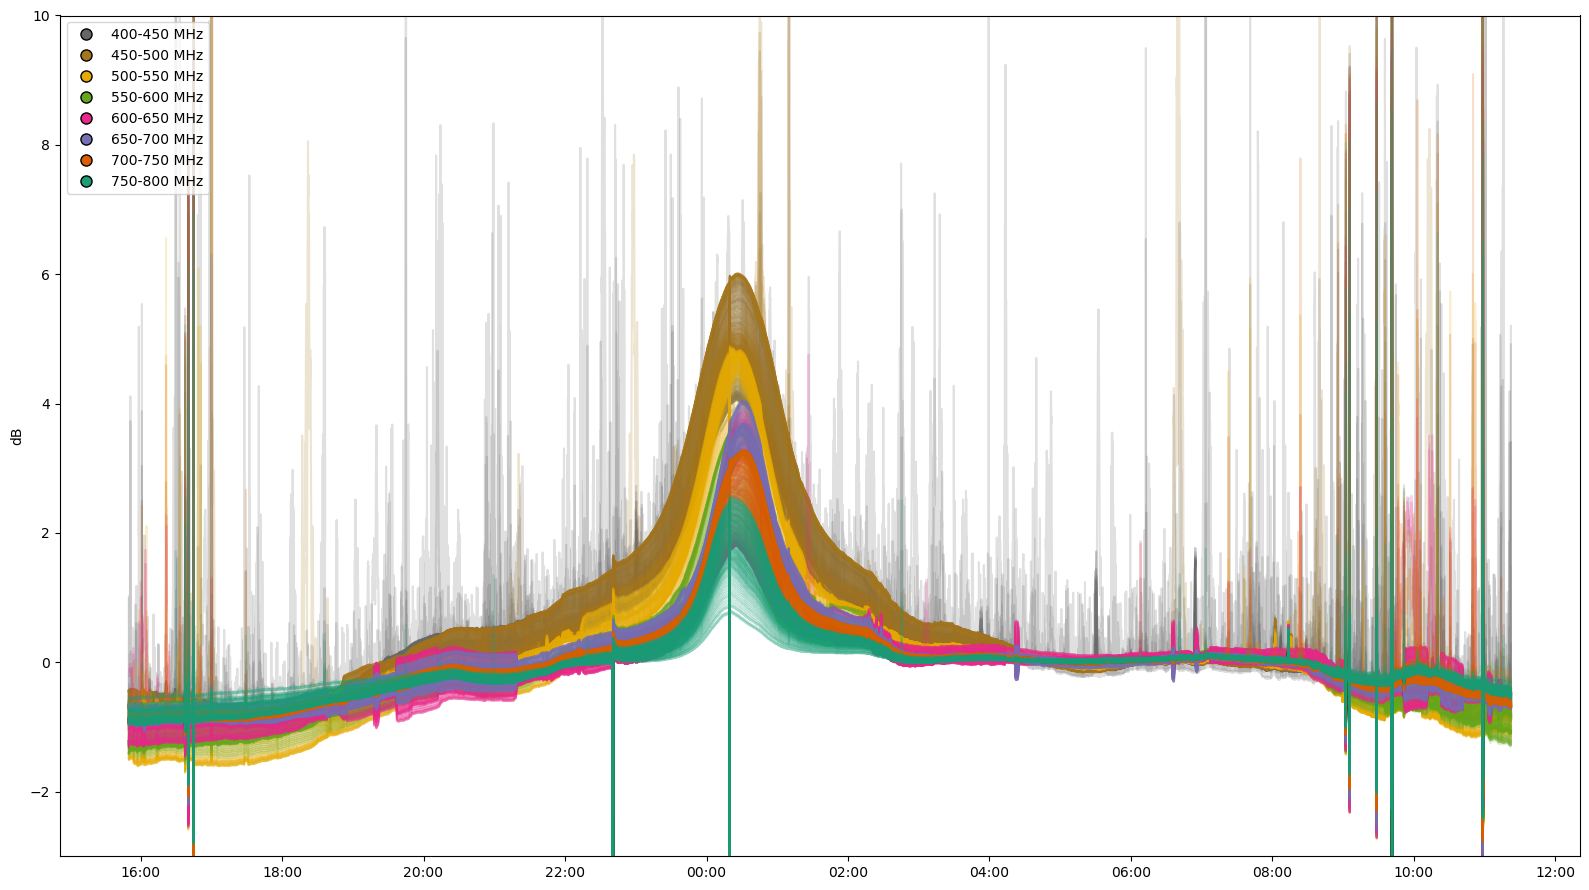

In [30]:
prod_idx=0

ylims = [-3,10]

x = times_sast

to_plot = np.real(vis[:,:-1,prod_idx])
scale = np.percentile(to_plot, 50, axis=0)
to_plot = to_plot/scale
to_plot = 10*np.log10(to_plot)

kf.plot_timeseries(to_plot, x, ylims=ylims, ylabel='dB')

### zoom in, replot

In [31]:
start_stop_time = ('2025-06-17T23:00:00',
                   '2025-06-18T02:00:00')

time_idxs = np.where((times_sast >= Time(start_stop_time[0])) & (times_sast <= Time(start_stop_time[1])))[0]

(<Figure size 1600x900 with 1 Axes>, <Axes: ylabel='dB'>)

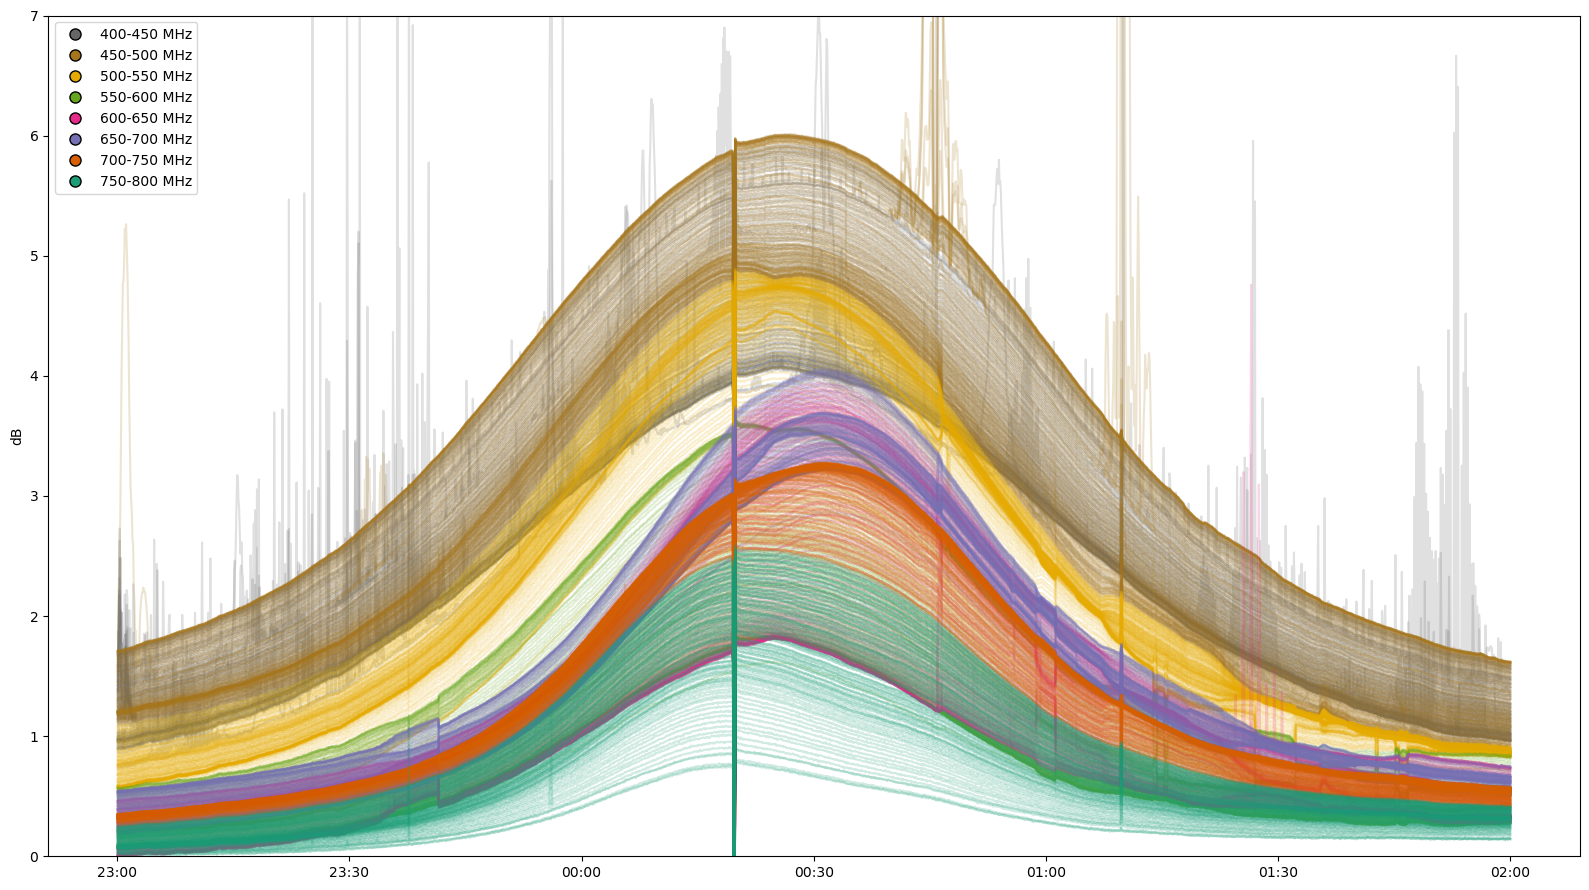

In [41]:
prod_idx=0

ylims = [0,7]

to_plot = np.real(vis[:,:-1,prod_idx])
scale = np.percentile(to_plot, 50, axis=0)
to_plot = to_plot/scale
to_plot = 10*np.log10(to_plot)

kf.plot_timeseries(to_plot[time_idxs], times_sast[time_idxs], ylims=ylims, ylabel='dB')

(<Figure size 1600x900 with 1 Axes>, <Axes: >)

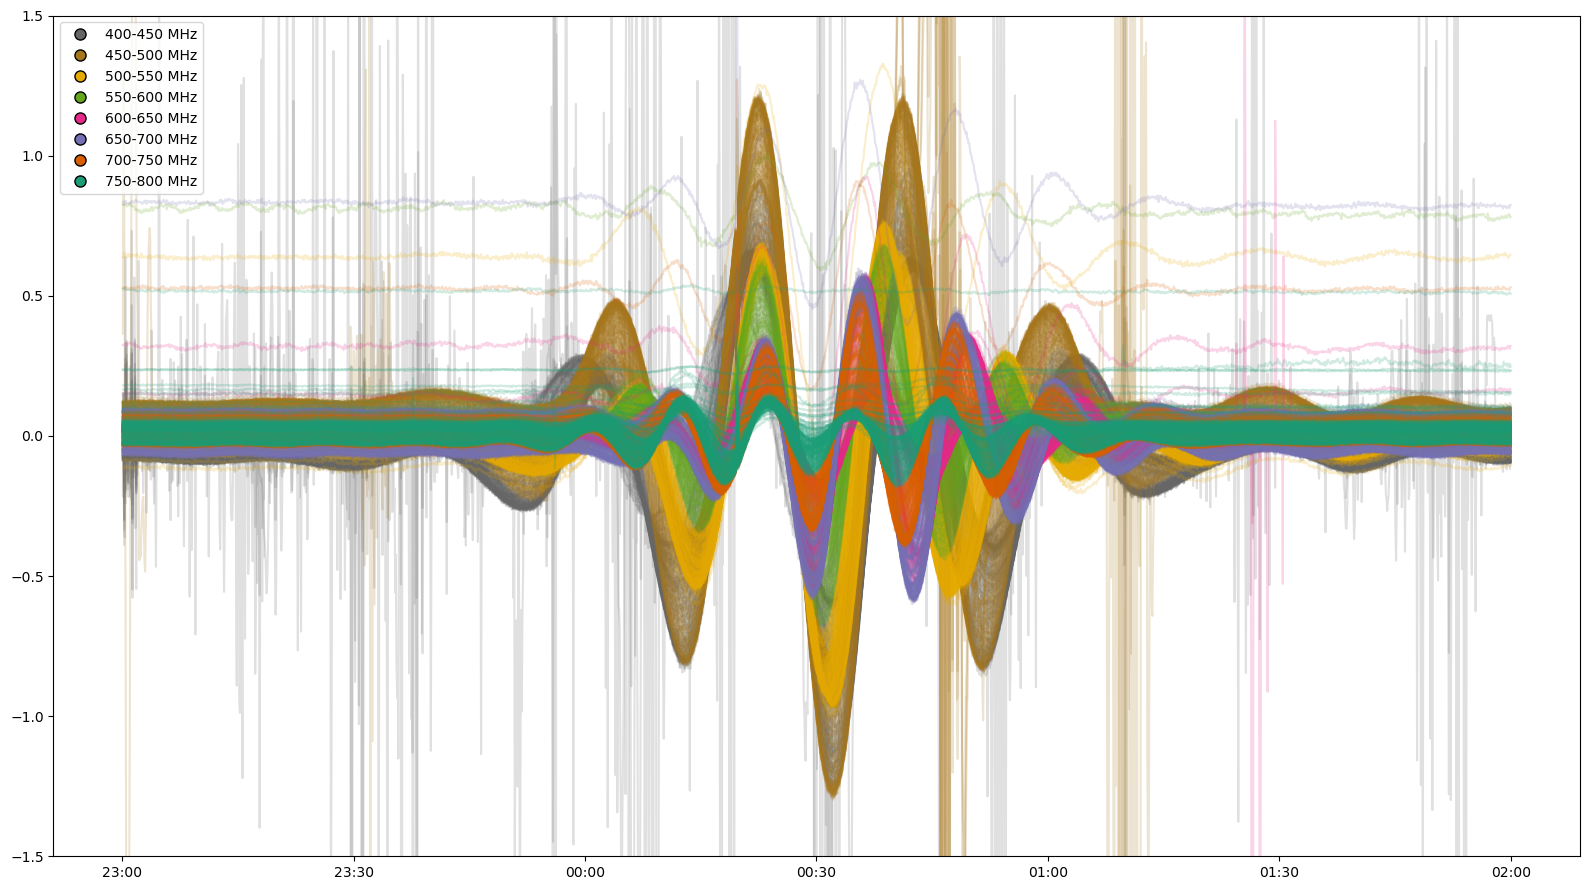

In [32]:
prod_idx=2

ylims = [-1.5,1.5]

x = times_sast[time_idxs]

to_plot = np.real(vis[time_idxs,:-1,prod_idx])
scale = np.percentile(to_plot, 50, axis=0)
#to_plot = to_plot - scale
#to_plot = 10*np.log10(to_plot)

kf.plot_timeseries(to_plot, x, ylims=ylims, ylabel='')

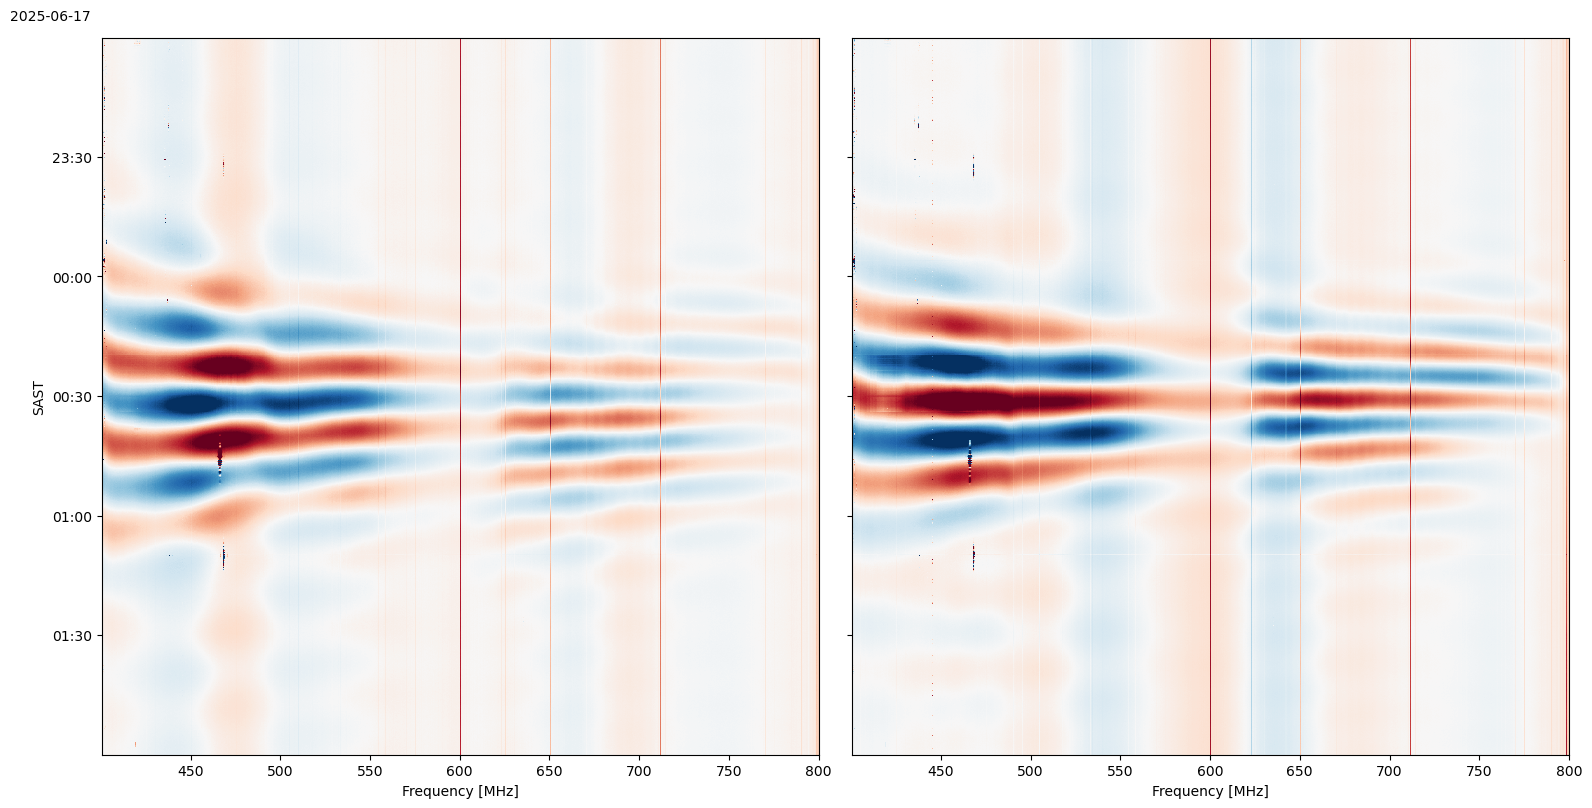

In [33]:
copol_idxs = [2, 6]

to_plot = np.real(vis[time_idxs])

fig, ax = kf.plot_waterfall_columns(to_plot, times_sast[time_idxs], freqs, copol_idxs, cmap='RdBu_r', vlims=[-1,1], scale=1, norm='linear')
fig.tight_layout()